In [1]:
"""Model Testing Notebook
"""
import json
import torch
from torchvision.models import vgg19
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from typing import Callable, List


def load_trained_vgg19(model_path: str) -> torch.nn.Module:
    model = vgg19()
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.7, inplace=False),
        torch.nn.Linear(in_features=4096, out_features=2048, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.7, inplace=False),
        torch.nn.Linear(in_features=2048, out_features=20, bias=True)
    )
    model_dict = torch.load(model_path)
    model.load_state_dict(model_dict["MODEL_STATE"])
    model.eval()
    return model


def load_test_dataloader(data_path: str) -> DataLoader:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    test_data = ImageFolder(root=data_path, transform=transform)

    return DataLoader(
        test_data,
        batch_size=32
    )


def load_labels_map() -> dict:
    # Loading in labels map from JSON
    labels_dict = {}
    with open('data/labels.json') as labels_json:
        labels_dict = json.load(labels_json)

    sorted_folder_list = list(sorted(labels_dict.keys()))

    # Only need the first 20 out of 100 classes.
    labels_map = {}
    for i in range(20):
        labels_map[i] = labels_dict[sorted_folder_list[i]]

    return labels_map


def load_all_training_metrics(metrics_path_list: List[str]) -> List[dict]:
    metrics_dict_list = list()
    for matrics_path in metrics_path_list:
        metrics_dict_list.append(torch.load(
            'saved_trained_output/' + matrics_path))
    return metrics_dict_list


def print_model_test_stats(model: torch.nn.Module,
                           test_loader: DataLoader,
                           labels_map: dict,
                           loss_func: Callable = F.cross_entropy
                           ) -> None:
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    classes_num = 20
    class_correct = list(0. for i in range(classes_num))
    class_total = list(0. for i in range(classes_num))

    for data, target in test_loader:
        output = model(data)
        loss = loss_func(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        for i in range(len(target)):
            label = target[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    t_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(t_loss))

    for i in range(classes_num):
        if class_total[i] > 0:
            percent_correct = 100 * class_correct[i] / class_total[i]
            print(
                f'Test Accuracy of Class: {labels_map[i]:19s}: {percent_correct:3.2f}%',
                f'({np.sum(int(class_correct[i]))}/{np.sum(int(class_total[i]))})')
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' %
                  (labels_map[i]))

    percent_correct = 100.0 * np.sum(class_correct) / np.sum(class_total)
    print(
        f'\nTest Accuracy (Overall): {percent_correct:3.2f}%',
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})')


In [30]:
# 1 Worker Test Accuracy
model = load_trained_vgg19('saved_trained_output/one_node.pt')
test_loader = load_test_dataloader('data/test')
labels_map = load_labels_map()
print('==[1 Worker Testing Breakdown]==')
print_model_test_stats(model, test_loader, labels_map)
print('*'*100)


==[1 Worker Testing Breakdown]==
Test Loss: 0.448489

Test Accuracy of Class: tench              : 92.00% (46/50)
Test Accuracy of Class: goldfish           : 98.00% (49/50)
Test Accuracy of Class: great white shark  : 76.00% (38/50)
Test Accuracy of Class: tiger shark        : 74.00% (37/50)
Test Accuracy of Class: hammerhead         : 84.00% (42/50)
Test Accuracy of Class: electric ray       : 74.00% (37/50)
Test Accuracy of Class: stingray           : 80.00% (40/50)
Test Accuracy of Class: chicken            : 76.00% (38/50)
Test Accuracy of Class: hen                : 86.00% (43/50)
Test Accuracy of Class: goldfinch          : 100.00% (50/50)
Test Accuracy of Class: indigo bird        : 94.00% (47/50)
Test Accuracy of Class: bulbul             : 90.00% (45/50)
Test Accuracy of Class: magpie             : 96.00% (48/50)
Test Accuracy of Class: chickadee          : 94.00% (47/50)
Test Accuracy of Class: water ouzel        : 90.00% (45/50)
Test Accuracy of Class: kite               : 

In [ ]:
# 2 Worker Test Accuracy
model = load_trained_vgg19('saved_trained_output/two_nodes.pt')
print('==[2 Worker Testing Breakdown]==')
print_model_test_stats(model, test_loader, labels_map)
print('*'*100)


==[2 Worker Testing Breakdown]==
Test Loss: 0.435099

Test Accuracy of Class: tench              : 92.00% (46/50)
Test Accuracy of Class: goldfish           : 98.00% (49/50)
Test Accuracy of Class: great white shark  : 74.00% (37/50)
Test Accuracy of Class: tiger shark        : 74.00% (37/50)
Test Accuracy of Class: hammerhead         : 84.00% (42/50)
Test Accuracy of Class: electric ray       : 72.00% (36/50)
Test Accuracy of Class: stingray           : 82.00% (41/50)
Test Accuracy of Class: chicken            : 68.00% (34/50)
Test Accuracy of Class: hen                : 92.00% (46/50)
Test Accuracy of Class: goldfinch          : 100.00% (50/50)
Test Accuracy of Class: indigo bird        : 98.00% (49/50)
Test Accuracy of Class: bulbul             : 92.00% (46/50)
Test Accuracy of Class: magpie             : 96.00% (48/50)
Test Accuracy of Class: chickadee          : 94.00% (47/50)
Test Accuracy of Class: water ouzel        : 88.00% (44/50)
Test Accuracy of Class: kite               : 

In [ ]:
# 4 Worker Test Accuracy
model = load_trained_vgg19('saved_trained_output/four_nodes.pt')
print('==[4 Worker Testing Breakdown]==')
print_model_test_stats(model, test_loader, labels_map)
print('*'*100)


==[4 Worker Testing Breakdown]==
Test Loss: 0.428579

Test Accuracy of Class: tench              : 92.00% (46/50)
Test Accuracy of Class: goldfish           : 98.00% (49/50)
Test Accuracy of Class: great white shark  : 76.00% (38/50)
Test Accuracy of Class: tiger shark        : 74.00% (37/50)
Test Accuracy of Class: hammerhead         : 86.00% (43/50)
Test Accuracy of Class: electric ray       : 74.00% (37/50)
Test Accuracy of Class: stingray           : 78.00% (39/50)
Test Accuracy of Class: chicken            : 74.00% (37/50)
Test Accuracy of Class: hen                : 90.00% (45/50)
Test Accuracy of Class: goldfinch          : 98.00% (49/50)
Test Accuracy of Class: indigo bird        : 96.00% (48/50)
Test Accuracy of Class: bulbul             : 94.00% (47/50)
Test Accuracy of Class: magpie             : 94.00% (47/50)
Test Accuracy of Class: chickadee          : 96.00% (48/50)
Test Accuracy of Class: water ouzel        : 90.00% (45/50)
Test Accuracy of Class: kite               : 7

In [ ]:
# 8 Worker Test Accuracy
model = load_trained_vgg19('saved_trained_output/eight_nodes.pt')
print('==[8 Worker Testing Breakdown]==')
print_model_test_stats(model, test_loader, labels_map)
print('*'*100)


==[8 Worker Testing Breakdown]==
Test Loss: 0.428733

Test Accuracy of Class: tench              : 92.00% (46/50)
Test Accuracy of Class: goldfish           : 98.00% (49/50)
Test Accuracy of Class: great white shark  : 80.00% (40/50)
Test Accuracy of Class: tiger shark        : 78.00% (39/50)
Test Accuracy of Class: hammerhead         : 82.00% (41/50)
Test Accuracy of Class: electric ray       : 74.00% (37/50)
Test Accuracy of Class: stingray           : 76.00% (38/50)
Test Accuracy of Class: chicken            : 74.00% (37/50)
Test Accuracy of Class: hen                : 90.00% (45/50)
Test Accuracy of Class: goldfinch          : 100.00% (50/50)
Test Accuracy of Class: indigo bird        : 98.00% (49/50)
Test Accuracy of Class: bulbul             : 92.00% (46/50)
Test Accuracy of Class: magpie             : 94.00% (47/50)
Test Accuracy of Class: chickadee          : 94.00% (47/50)
Test Accuracy of Class: water ouzel        : 88.00% (44/50)
Test Accuracy of Class: kite               : 

In [ ]:
import glob
import os
os.chdir('saved_trained_output')
metric_dict_list = glob.glob('*_metrics.pt')
# Swapping to be in correct order
metric_dict_list[0], metric_dict_list[1], metric_dict_list[2], metric_dict_list[3] = (
    metric_dict_list[2], metric_dict_list[3], metric_dict_list[1], metric_dict_list[0]
)
print(metric_dict_list)
os.chdir('..')
# Loading in all training metrics for all 4 experiments
metric_dicts = load_all_training_metrics(metric_dict_list)
dict_keys = metric_dicts[0].keys()
print(dict_keys)


['one_node_metrics.pt', 'two_nodes_metrics.pt', 'four_nodes_metrics.pt', 'eight_nodes_metrics.pt']
dict_keys(['EPOCHS_RUN', 'RUN_TIME', 'TRAIN_HISTORY', 'VALID_HISTORY', 'EPOCH_TIMES', 'LOWEST_LOSS'])


In [ ]:
# Printing lowest validation loss achieved for each experiment
for i in range(4):
    loss = metric_dicts[i]["LOWEST_LOSS"]
    experiment = metric_dict_list[i][:-11]
    print(
        f'Experiment: {experiment:11s} had lowest validation loss of {loss:.6f}')


Experiment: one_node    had lowest validation loss of 0.379511
Experiment: two_nodes   had lowest validation loss of 0.364552
Experiment: four_nodes  had lowest validation loss of 0.355783
Experiment: eight_nodes had lowest validation loss of 0.352181


In [ ]:
# Printing average epoch time for each experiment, and the number of epochs completed
avg_epoch_times = list()  # to be used later for graphs
max_epochs = list()     # to be used later for graphs
print("Each experiment ran for 2 hours.\n")
for i in range(4):
    experiment = metric_dict_list[i][:-11]
    epochs_run = metric_dicts[i]["EPOCHS_RUN"]
    avg_epoch_time = (metric_dicts[i]["RUN_TIME"] / epochs_run) / 60.0
    print(f'Experiment: [{experiment}] ran for a total of {epochs_run} epochs,\n',
          f'and had an average epoch time of {avg_epoch_time:.2f} minutes\n')
    max_epochs.append(epochs_run)
    avg_epoch_times.append(avg_epoch_time)

# Each of the following lists now contains the timings of epochs in minutes
# Will be used to show validation loss drop off with respect to time (instead of epoch num)
epoch_times = list()
for j in range(4):
    epoch_times.append([avg_epoch_times[j] * i for i in range(max_epochs[j])])


Each experiment ran for 2 hours.

Experiment: [one_node] ran for a total of 14 epochs,
 and had an average epoch time of 8.76 minutes

Experiment: [two_nodes] ran for a total of 23 epochs,
 and had an average epoch time of 5.40 minutes

Experiment: [four_nodes] ran for a total of 36 epochs,
 and had an average epoch time of 3.35 minutes

Experiment: [eight_nodes] ran for a total of 51 epochs,
 and had an average epoch time of 2.37 minutes



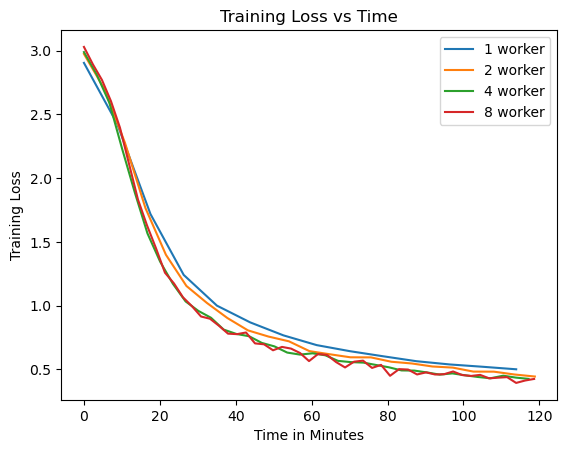

In [28]:
# Train loss across epoch times for each experiment
import matplotlib.pyplot as plt

nodes = [1, 2, 4, 8]
for i in range(len(epoch_times)):
    plt.plot(epoch_times[i], metric_dicts[i]
             ["TRAIN_HISTORY"], label=f'{nodes[i]} worker')
    plt.legend()

plt.title("Training Loss vs Time")
plt.xlabel("Time in Minutes")
plt.ylabel("Training Loss")
plt.savefig('presentation_stuff/TrainingLoss.png')
plt.show()


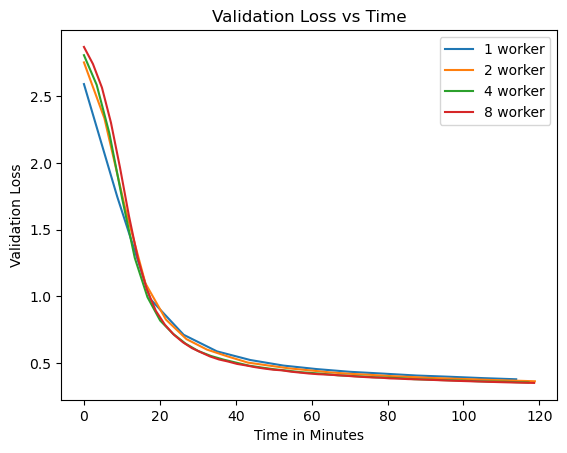

In [29]:
# Train loss across epoch times for each experiment
import matplotlib.pyplot as plt

for i in range(len(epoch_times)):
    plt.plot(epoch_times[i], metric_dicts[i]
             ["VALID_HISTORY"], label=f'{nodes[i]} worker')
    plt.legend()

plt.title("Validation Loss vs Time")
plt.xlabel("Time in Minutes")
plt.ylabel("Validation Loss")
plt.savefig('presentation_stuff/ValidationLoss.png')
plt.show()
